In [1]:
# import libraries
%matplotlib inline

import numpy as np                          # General math operations
import scipy.io as sio                      # Loads .mat variables
import matplotlib.pyplot as plt             # Data visualization
from mpl_toolkits.mplot3d import Axes3D     # 3D data visualization
import skfuzzy as fuzz                      # Fuzzy toolbox
import math
import scipy.integrate as spi               # simpson
from pyeasyga import pyeasyga               # Genetic algorithms
import random                               # RNG for GA implementation

class expData (object):
    fuzzyLookupTable = 0
    def __init__(self, fileName):
        # Load dataset of the weather for typical meteorological months into a dictionary
        dataset = sio.loadmat(fileName)
        self.cad = dataset['cad']          # Cadance
        self.heart = dataset['heart']         # Heart Rate
        self.p = dataset['power']          # power
        self.torq = dataset['torq']      #torque
        self.time = dataset['time']       # Total number of data second
    def plotC (self):
        f, axarr = plt.subplots(3, sharex = True)
        axarr[0].plot(self.time, self.p)
        axarr[0].set_title('time vs power')
        axarr[1].plot(self.time, self.heart)
        axarr[1].set_title('time vs heart rate')
        axarr[2].plot(self.p, self.heart)
        axarr[2].set_title('power vs heart')
        plt.show()
        
    

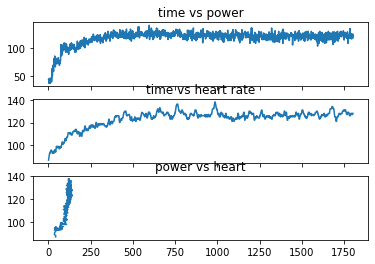

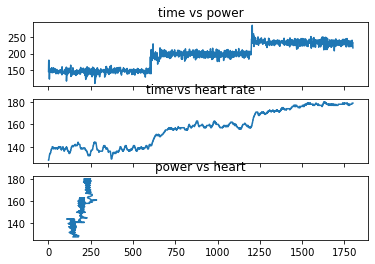

In [2]:
cP = expData('cHR_1124.mat')  
cP.plotC()
cP = expData('cP_1124.mat')  
cP.plotC()


In [3]:
def discDer(fn,step):
    der = np.zeros(len(fn))
    for n in range(len(fn)):
        if n ==0:
            der[n] = (fn[1]-fn[0])/step
        elif n<(len(fn)-1):
            der[n] = (fn[n+1]-fn[n-1])/(2*step)
        else:
            der[n] = fn[n]-fn[n-1]
    return der

def trapInt(f,step):
    S = np.zeros(len(f))
    for n in range (len(f)):
        intF = f[0:n+1]
        S[n] = spi.simps(intF)
    return S


In [91]:
#f = None
#u = None
def p2hr(filename,a1,a2,a3,a4,a5,a6,c):
        #global f,u
        cP = expData(filename)    

        # x1 = given data
        x1 = (cP.heart-cP.heart[0])/max(max(cP.heart))
        t = cP.time
        f = np.transpose(x1)[0]
        #print(f,x1)
        cPp = (cP.p-cP.p[0])/max(max(cP.p))
        u = np.transpose(cPp)[0]

        x1pEq = np.zeros(len(f))
        x1pR = np.zeros(len(f))

        # 
        for n in range(len(f)):
            x1pEq[n] = (a4*round(math.exp(a3*n),10)*f[n])/(math.exp(a5-f[n])+1) 

        intX1 = trapInt(x1pEq,1)

        for n in range(len(f)):
            x1pR[n] =-a1*f[n]+a2*(round(math.exp(-a3*n),10)*(x1pEq[n]))+a6*(u[n])

        resX1 = trapInt(x1pR,1)
        return [t,x1pR,x1pEq,resX1,x1]
        
def p2hrPlt(t,x1pR,x1pEq,resX1,x1) :       
        f, subplt = plt.subplots(2, sharex = True)
        subplt[0].plot(t,x1pR,label = 'xqpR')
        subplt[0].plot(t,x1pEq,label = 'x1pEq')
        subplt[0].legend()

        subplt[1].plot(t,resX1,label = 'resx1')
        subplt[1].plot(t,x1,label = 'x1')
        subplt[1].legend()
        
        RMSE = np.sqrt(np.sum((resX1 - x1) ** 2) / len(x1)) 
        print('RMSE is ',RMSE)

In [56]:
cP = expData('cHR_1124.mat')
max(max(cP.p))

142

5.141485490071189
RMSE is  5.141485490071189


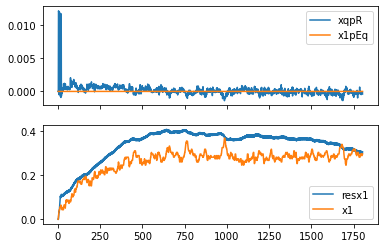

In [96]:
# ongoing
cP = p2hr('cHR_1124.mat',a1 = 0.0139, a2 = 0.072, a3 = 0.0049, a4 = 0.0041, a5 = 19.8002, a6 = 0.006999,c=0)
print(np.sqrt(np.sum((cP[3] - cP[4]) ** 2) / len(cP[4])))
p2hrPlt(cP[0],cP[1],cP[2],cP[3],cP[4])

RMSE is  5.141485490071188


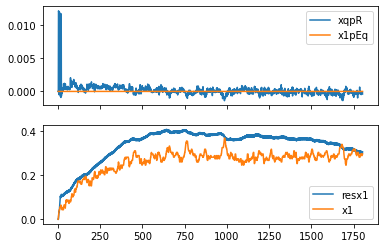

In [7]:
# tmp
cP = p2hr('cHR_1124.mat',a1 = 0.0139, a2 = 0.072, a3 = 0.0049, a4 = 0.0041, a5 = 19.8002, a6 = 0.006999,c=0)
p2hrPlt(cP[0],cP[1],cP[2],cP[3],cP[4])

In [92]:
def create_individual(data):
    """ Create a candidate solution representation
        Represented as an array of a1 to a6 and c with different intervals 
    """
    individual = np.zeros((7,))
    individual[0] = random.uniform(0, 0.0140)  # a1 value
    individual[1] = random.uniform(0, 0.1) #a2 value
    individual[2] = random.uniform(0, 0.1)  # a3 value
    individual[3] = random.uniform(0, 0.1)  # a4 value
    individual[4] = random.uniform(0, 20)  # a5 value
    individual[5] = random.uniform(0, 0.10)  # a6 value
    individual[6] = random.uniform(0, 0.10)  # c value
    return individual

def crossover(parent_1, parent_2):
    """ Crossover two parents to produce two children
        Performs a weighted arithmetic recombination
    """
    ratio = random.uniform(-1, 1)  # Generate a number from -1 to 1
    crossIndices = np.random.choice([0, 1], size=(len(parent_1),), p=[0.5, 0.5])  # Determine if x and/or y value is operated on
    child_1 = parent_1
    child_2 = parent_2
    for i in range(len(crossIndices)):
        if (crossIndices[i] == 1):
            child_1[i] = child_1[i] + ratio * child_2[i]  # Perform weighted sum
            child_2[i] = child_2[i] + ratio * child_1[i]
    return child_1, child_2

def mutate(individual):
    """ Mutate an individual to introduce new genetic information to the population
        Adds a random number from 0 to 9 to each allele in the individual (up to two decimal places)
    """
    mutateIndices = np.random.choice([0, 1], size=(4,), p=[0.8, 0.2])
    for index in range(len(mutateIndices)):
        if(mutateIndices[index] == 1):
            individual[0] += random.randint(1, 9) * (10**(index - 5))  # a1 value
            individual[1] += random.randint(1, 9) * (10**(index - 5))  # a2 value
            individual[2] += random.randint(1, 9) * (10**(index - 5))  # a3 value
            individual[3] += random.randint(1, 9) * (10**(index - 5))  # a4 value
            individual[4] += random.randint(1, 9) * (10**(index - 5))  # a5 value
            individual[5] += random.randint(1, 9) * (10**(index - 5))  # a6 value
            individual[6] += random.randint(1, 9) * (10**(index - 5))  # c value

def fitness(individual, data):
    """ Calculate fitness of a candidate solution representation
    """
    a1  = round(individual[0],6)
    a2  = round(individual[1],6)
    a3  = round(individual[2],6)
    a4  = round(individual[3],6)
    a5  = round(individual[4],6)
    a6  = round(individual[5],6)
    c  = round(individual[6],6)
    filename = 'cHR_1124.mat'
    #print(a1,a2,a3,a4,a5,a6,c)
    cP = p2hr(filename,a1,a2,a3,a4,a5,a6,c)
    fitness = np.sqrt(np.sum((cP[3] - cP[4]) ** 2) / len(cP[4]))
    return fitness

In [93]:
inputData = np.random.rand(1800)

ga = pyeasyga.GeneticAlgorithm(
    inputData,
    population_size = 30,
    generations = 50,
    crossover_probability = 0.8,
    mutation_probability = 0.005,
    maximise_fitness = False 
)
ga.create_individual = create_individual
ga.crossover_function = crossover
ga.mutate_function = mutate
ga.selection_function = ga.tournament_selection
ga.fitness_function = fitness

ga.run()
bestSoln = ga.best_individual()
print("Fitness = ",bestSoln[0], "Solution = ",bestSoln[1])
# print("Solution = ",bestSoln[1])

Fitness =  2.979752123106376 Solution =  [ 1.62653504e-02  6.99340471e-02 -3.92045781e-02 -2.96212396e-02
 -1.71366524e+02  8.32151494e-03  6.65028340e-02]


RMSE is  2.9865850147002146


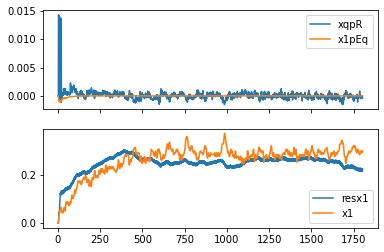

In [94]:
cP = p2hr('cHR_1124.mat',a1 = bestSoln[1][0], a2 = bestSoln[1][1], a3 = bestSoln[1][2], a4 = bestSoln[1][3], a5 = bestSoln[1][4], a6 = bestSoln[1][5],c=bestSoln[1][6])
p2hrPlt(cP[0],cP[1],cP[2],cP[3],cP[4])

RMSE is  2.664815286208669


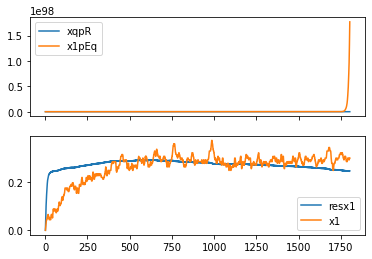

In [89]:
#Fitness =  2.6647667560282455 Solution =  [2.84173135e-03 4.05326486e-02 1.43278051e-01 1.57134161e-01 2.90526478e+01 1.39233844e-03 7.74331445e-01]
cP = p2hr('cHR_1124.mat',a1 = bestSoln[1][0], a2 = bestSoln[1][1], a3 = bestSoln[1][2], a4 = bestSoln[1][3], a5 = bestSoln[1][4], a6 = bestSoln[1][5],c=bestSoln[1][6])
p2hrPlt(cP[0],cP[1],cP[2],cP[3],cP[4])

#create initial population
population = 30

pop = []
popFit = []
resPop = []
ranPop = []
for i in range(population):
    pop.append(create_individual())
    popFit.append(fitness(pop[i]))
    resPop.append([i,pop[i],popFit[i]])

ranPop = rankPop(resPop)
#select the top 15 and mutate & crossover them 
selPop = population/2
finPop = ranPop[0:int(selPop)]
nGenPop = mutate(finPop)

In [66]:
finPop[]

TypeError: 'list' object is not callable

<h1>Test Python Materials</h1>

In [49]:
# test setting

def create_individual(data):
    """ Create a candidate solution representation
        Represented as an array of x and y floating-point values from -10 to 10
    """
    individual = np.zeros((1,))
    individual[0] = random.uniform(-10, 10)  # X value
    print("individual is ",individual,"\n")
    #print("data is ",data,"\n")
    return individual

def crossover(parent_1, parent_2):
    """ Crossover two parents to produce two children
        Performs a weighted arithmetic recombination
    """
    ratio = random.uniform(-1, 1)  # Generate a number from -1 to 1
    crossIndices = np.random.choice([0, 1], size=(len(parent_1),), p=[0.5, 0.5])  # Determine if x and/or y value is operated on
    child_1 = parent_1
    child_2 = parent_2
    for i in range(len(crossIndices)):
        if (crossIndices[i] == 1):
            child_1[i] = child_1[i] + ratio * child_2[i]  # Perform weighted sum
            child_2[i] = child_2[i] + ratio * child_1[i]
    print("child_1: ",child_1,"\n")
    print("child_2: ",child_2,"\n")
    return child_1, child_2

def mutate(individual):
    """ Mutate an individual to introduce new genetic information to the population
        Adds a random number from 0 to 9 to each allele in the individual (up to two decimal places)
    """
    mutateIndices = np.random.choice([0, 1], size=(4,), p=[0.8, 0.2])
    for index in range(len(mutateIndices)):
        if(mutateIndices[index] == 1):
            individual[0] += random.randint(1, 9) * (10**(index - 2))
        print("ind after mutation is ",individual,"\n")

def fitness(individual, data):
    """ Calculate fitness of a candidate solution representation
    """
    gX  = individual[0]
    fitness = gX**2
    print("Fitness = ",fitness,"\n")
    #print("data is ",data,"\n")
    return fitness

In [50]:

inputData = np.random.rand(10,10)

ga = pyeasyga.GeneticAlgorithm(
    inputData,
    population_size = 30,
    generations = 50,
    crossover_probability = 0.8,
    mutation_probability = 0.005,
    maximise_fitness = False 
)
ga.create_individual = create_individual
ga.crossover_function = crossover
ga.mutate_function = mutate
ga.selection_function = ga.tournament_selection
ga.fitness_function = fitness

ga.run()
bestSoln = ga.best_individual()
print("Fitness = ",bestSoln[0], "Solution = ",bestSoln[1])
# print("Solution = ",bestSoln[1])

individual is  [-6.01398505] 

individual is  [9.76857328] 

individual is  [-1.07484548] 

individual is  [-3.6365259] 

individual is  [2.31332925] 

individual is  [-5.24692549] 

individual is  [-6.66378115] 

individual is  [1.13353124] 

individual is  [7.86735658] 

individual is  [-4.53381332] 

individual is  [5.31356961] 

individual is  [-4.56698747] 

individual is  [-0.00488894] 

individual is  [1.60474122] 

individual is  [5.90256774] 

individual is  [-8.18172316] 

individual is  [6.25091985] 

individual is  [9.37643845] 

individual is  [-4.29098809] 

individual is  [3.53789514] 

individual is  [5.47009818] 

individual is  [-5.17415064] 

individual is  [-2.66567102] 

individual is  [6.14547683] 

individual is  [-5.82699562] 

individual is  [5.54826534] 

individual is  [-6.75780918] 

individual is  [8.05674337] 

individual is  [-0.95447876] 

individual is  [1.72297733] 

Fitness =  36.16801623423874 

Fitness =  95.42502391786823 

Fitness =  1.15529281405

Fitness =  5.678450794129558e-12 

Fitness =  2.7464858475780114e-10 

Fitness =  5.8906160774570475e-12 

Fitness =  1.9013076562951825e-10 

Fitness =  2.3610664058015904e-10 

Fitness =  1.9013076562951825e-10 

Fitness =  6.961465928348808e-11 

Fitness =  2.856075483550602e-10 

Fitness =  1.7186298782043153e-10 

Fitness =  1.9013076562951825e-10 

Fitness =  6.961465928348808e-11 

Fitness =  5.8906160774570475e-12 

Fitness =  2.8998122957842095e-10 

Fitness =  6.961465928348808e-11 

Fitness =  2.3610664058015904e-10 

Fitness =  5.8906160774570475e-12 

Fitness =  1.8628955207140723e-10 

child_1:  [-7.20699758e-06] 

child_2:  [9.47831137e-07] 

child_1:  [-1.58629686e-06] 

child_2:  [-4.34378521e-07] 

child_1:  [-9.19854073e-06] 

child_2:  [-5.6675073e-06] 

child_1:  [-1.56364521e-05] 

child_2:  [-1.43307079e-05] 

child_1:  [3.2150893e-06] 

child_2:  [-3.08936764e-06] 

child_1:  [2.71511504e-06] 

child_2:  [-2.42705914e-06] 

child_1:  [-8.34353997e-06] 

child_2:

child_2:  [-1.65554534e-11] 

child_1:  [4.7137657e-11] 

child_2:  [-3.38606344e-11] 

child_1:  [2.91012882e-12] 

child_2:  [8.35974953e-12] 

child_1:  [-4.99108802e-12] 

child_2:  [3.46102654e-12] 

child_1:  [-6.54400533e-12] 

child_2:  [-5.9179107e-11] 

child_1:  [2.66307094e-11] 

child_2:  [-1.16080084e-11] 

child_1:  [1.09222871e-11] 

child_2:  [-1.64143676e-11] 

child_1:  [-1.60995725e-11] 

child_2:  [5.0085345e-12] 

child_1:  [1.45538115e-11] 

child_2:  [-1.88164794e-11] 

child_1:  [-6.54400533e-12] 

child_2:  [-1.60995725e-11] 

child_1:  [-1.77547339e-11] 

child_2:  [1.08759095e-11] 

child_1:  [6.67997687e-12] 

child_2:  [7.23776869e-12] 

child_1:  [-1.2475095e-12] 

child_2:  [-1.15227545e-11] 

child_1:  [-1.37896496e-11] 

child_2:  [1.32393806e-11] 

Fitness =  2.508541783972161e-23 

Fitness =  8.164191159646124e-23 

Fitness =  2.7367837865487736e-22 

Fitness =  2.7408303591527765e-22 

Fitness =  2.221958710493793e-21 

Fitness =  1.146542564080078e

Fitness =  4.482837779845718e-31 

Fitness =  4.482837779845718e-31 

Fitness =  9.042264563217573e-31 

Fitness =  8.333377242938367e-31 

Fitness =  4.482837779845718e-31 

Fitness =  6.699029730537901e-33 

Fitness =  2.49519912350236e-32 

Fitness =  6.699029730537901e-33 

child_1:  [6.15512098e-16] 

child_2:  [-3.24454009e-16] 

child_1:  [6.83813044e-16] 

child_2:  [3.52518881e-16] 

child_1:  [7.75721172e-17] 

child_2:  [1.36909372e-16] 

child_1:  [8.18476006e-17] 

child_2:  [8.18476006e-17] 

child_1:  [8.18476006e-17] 

child_2:  [1.57961993e-16] 

child_1:  [8.18476006e-17] 

child_2:  [8.18476006e-17] 

child_1:  [1.90301197e-17] 

child_2:  [1.50394197e-16] 

child_1:  [1.23239371e-16] 

child_2:  [8.60595267e-17] 

child_1:  [1.81869833e-16] 

child_2:  [1.34972125e-16] 

child_1:  [4.69539766e-16] 

child_2:  [8.88045457e-16] 

child_1:  [8.18476006e-17] 

child_2:  [8.18476006e-17] 

child_1:  [4.26150301e-16] 

child_2:  [2.42538858e-17] 

Fitness =  6.69902973053

In [45]:
from pyeasyga.pyeasyga import GeneticAlgorithm

data = [('pear', 50), ('apple', 35), ('banana', 40)]
ga = GeneticAlgorithm(data)

def fitness (individual, data):
    fitness = 0
    if individual.count(1) == 2:
        print("count: ",individual)
        for (selected, (fruit, profit)) in zip(individual, data):
                 if selected:
                    fitness += profit
                    print(selected)
    return fitness

ga.fitness_function = fitness
ga.run()
print (ga.best_individual())

count:  [1, 1, 0]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 1, 0]
1
1
count:  [1, 0, 1]
1
1
count:  [0, 1, 1]
1
1
count:  [0, 1, 1]
1
1
count:  [0, 1, 1]
1
1
count:  [1, 1, 0]
1
1
count:  [1, 0, 1]
1
1
count:  [0, 1, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 1, 0]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [0, 1, 1]
1
1
count:  [1, 1, 0]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [0, 1, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 1, 0]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [0, 1, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1

1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  

1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  

1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  

count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1, 0, 1]
1
1
count:  [1

In [13]:
sinfn = np.zeros(101)
cosfn = np.zeros(101)
recSin = np.zeros(101)
recCos = np.zeros(101)

for n in range(101):
    sinfn[n] = math.sin(n)
    cosfn[n] = math.cos(n)
recCos = trapInt(-sinfn,1)

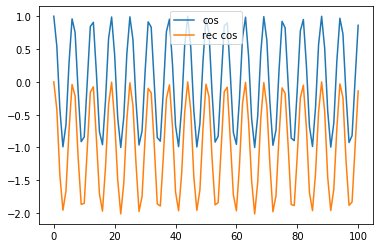

In [68]:
plt.plot(cosfn,label = 'cos')
plt.plot(recCos,label = 'rec cos')
plt.legend()

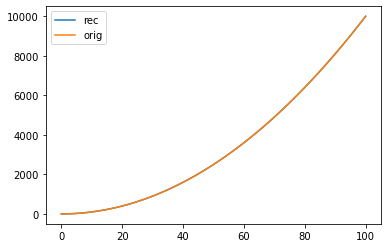

In [73]:
origFn = np.zeros(101)
fnInt = np.zeros(101)
x = np.arange(0,101,1)
origFn = 2*x
fnInt = trapInt(origFn,1)
origIn = x**2

plt.plot(fnInt,label = 'rec')
plt.plot(origIn,label = 'orig')
plt.legend()

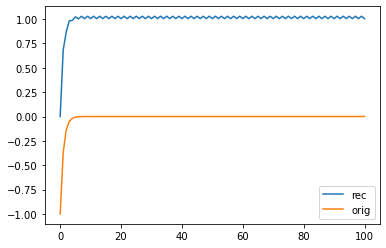

In [87]:
origFn = np.zeros(101)
fnInt = np.zeros(101)
for x in range (100):
    origFn[x] = math.exp(-x)
origIn = -1*origFn
fnInt = trapInt(origFn,1)
    
plt.plot(fnInt,label = 'rec')
plt.plot(origIn,label = 'orig')
plt.legend()

In [85]:
origIn

-1.0112214926104486e-43

In [47]:
y =np.arange(0,10,1)
y[0:-1:2] #start stopbefore step

array([0, 2, 4, 6, 8])